[Source for tutorial](https://github.com/pgmpy/pgmpy_notebook/blob/master/notebooks/9.%20Learning%20Bayesian%20Networks%20from%20Data.ipynb)

# Learning Bayesian Networks from Data
Previous notebooks showed how Bayesian networks encode a probability distribution over a set of variables and how
they can be used to predict variable states or to generate new samples from the joint distribution. This section
will be about obtaining a Bayesian network given a set of sample data. Learning the network can be split into two
problems:
* **Parameter Learning:** Given a set of data samples and a DAG that captures dependencies between the variables,
estimate the conditional probability distributions of the individual variables.
* **Structure Learning:** Given a set of data samples, estimate a DAG that captures the dependencies between the
variables.

Currently, `pgmpy` supports:
* parameter learning for *discrete* nodes using algorithms
  * Maximum Likelihood Estimation, and
  * Bayesian Estimation
* structure learning for *discrete* and *fully observed* networks using the algorithms:
  * Score-based structure estimation (BIC / BDEU / K2 score)
  * Constraint-based structure estimation (PC)
  * Hybrid structure estimation (MMHC)

Doing path-setting:

In [1]:
import os
import sys
from typing import *
from typing import Union, List, Any

import itertools

os.getcwd()
# Setting the baseline:
os.chdir('/development/projects/statisticallyfit/github/learningmathstat/PythonNeuralNetNLP')


curPath: str = os.getcwd() + "/src/PgmpyStudy/"

dataPath: str = curPath + "data/"

imagePath: str = curPath + 'images/'

print("curPath = ", curPath, "\n")
print("dataPath = ", dataPath, "\n")
print('imagePath = ', imagePath, "\n")


# Making files in utils folder visible here: to import my local print functions for nn.Module objects
sys.path.append(os.getcwd() + "/src/utils/")
# For being able to import files within PgmpyStudy folder
sys.path.append(curPath)

sys.path

curPath =  /development/projects/statisticallyfit/github/learningmathstat/PythonNeuralNetNLP/src/PgmpyStudy/ 

dataPath =  /development/projects/statisticallyfit/github/learningmathstat/PythonNeuralNetNLP/src/PgmpyStudy/data/ 

imagePath =  /development/projects/statisticallyfit/github/learningmathstat/PythonNeuralNetNLP/src/PgmpyStudy/images/ 



['/development/projects/statisticallyfit/github/learningmathstat/PythonNeuralNetNLP/src/PgmpyStudy',
 '/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python37.zip',
 '/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7',
 '/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/lib-dynload',
 '',
 '/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages',
 '/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/IPython/extensions',
 '/home/statisticallyfit/.ipython',
 '/development/projects/statisticallyfit/github/learningmathstat/PythonNeuralNetNLP/src/utils/',
 '/development/projects/statisticallyfit/github/learningmathstat/PythonNeuralNetNLP/src/PgmpyStudy/']

Science imports:

In [2]:
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete import TabularCPD
from pgmpy.factors.discrete import JointProbabilityDistribution
from pgmpy.factors.discrete.DiscreteFactor import DiscreteFactor
from pgmpy.independencies import Independencies
from pgmpy.independencies.Independencies import IndependenceAssertion


from operator import mul
from functools import reduce


from src.utils.GraphvizUtil import *
from src.utils.NetworkUtil import *


import pandas as pd
from pandas import DataFrame

## Parameter Learning
Supposed we have the following data:

In [3]:
fruitData: DataFrame = DataFrame(data = {'fruit': ["banana", "apple", "banana", "apple", "banana","apple", "banana",
                                              "apple", "apple", "apple", "banana", "banana", "apple", "banana",],
                                    'tasty': ["yes", "no", "yes", "yes", "yes", "yes", "yes",
                                              "yes", "yes", "yes", "yes", "no", "no", "no"],
                                    'size': ["large", "large", "large", "small", "large", "large", "large",
                                             "small", "large", "large", "large", "large", "small", "small"]})

fruitData

,fruit,tasty,size
0,banana,yes,large
1,apple,no,large
2,banana,yes,large
3,apple,yes,small
4,banana,yes,large
5,apple,yes,large
6,banana,yes,large
7,apple,yes,small
8,apple,yes,large
9,apple,yes,large


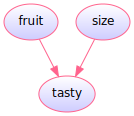

In [4]:
fruitModel = BayesianModel([('fruit', 'tasty'), ('size', 'tasty')])

pgmpyToGraph(fruitModel)

### 1/ State Counts
To make sense of the given data we can count how often each state of the variable occurs. If the variable is dependent on parents, the counts are done conditionally on the parents' states, so separately for each parent configuration.

In [5]:
from pgmpy.estimators import ParameterEstimator

pe: ParameterEstimator = ParameterEstimator(model = fruitModel, data = fruitData)

print(pe.state_counts(variable = 'fruit')) # example of unconditional state counts
print('\n', pe.state_counts('tasty')) # example of conditional count of fruit and size

        fruit
apple       7
banana      7

 fruit apple       banana      
size  large small  large small
tasty                         
no      1.0   1.0    1.0   1.0
yes     3.0   2.0    5.0   0.0


Can see that as many apples as bananas were observed and that $5$ large bananas were tasty while the only small one was not.

### 2/ Maximum Likelihood Estimation
A natural estimate for the CPDs is to use the *relative frequencies* (probabilities version of the state count table above). For instance we observed $7$ apples among a total of $14$ fruits, so we might guess that about half the fruits are apples.

This approach is **Maximum Likelihood Estimation (MLE)**: this fills the CPDs in such a way that $P(\text{data} \; | \; \text{model})$ is maximumal, and this is achieved using the *relative frequencies*. The `mle.estimate_cpd(variable)` function computes the state counts and divides each cell by the (conditional) sample size.

In [6]:

from pgmpy.estimators import MaximumLikelihoodEstimator

mle: MaximumLikelihoodEstimator = MaximumLikelihoodEstimator(model = fruitModel, data = fruitData)

assert mle.state_names == {'fruit': ['apple', 'banana'], 'tasty': ['no', 'yes'], 'size': ['large', 'small']}


estCPD_fruit: TabularCPD = mle.estimate_cpd('fruit') # unconditional
print(estCPD_fruit)
estCPD_size: TabularCPD = mle.estimate_cpd("size")
print(estCPD_size)

estCPD_tasty: TabularCPD = mle.estimate_cpd('tasty') # conditional
print(estCPD_tasty)

+---------------+-----+
| fruit(apple)  | 0.5 |
+---------------+-----+
| fruit(banana) | 0.5 |
+---------------+-----+
+-------------+----------+
| size(large) | 0.714286 |
+-------------+----------+
| size(small) | 0.285714 |
+-------------+----------+
+------------+--------------+--------------------+---------------------+---------------+
| fruit      | fruit(apple) | fruit(apple)       | fruit(banana)       | fruit(banana) |
+------------+--------------+--------------------+---------------------+---------------+
| size       | size(large)  | size(small)        | size(large)         | size(small)   |
+------------+--------------+--------------------+---------------------+---------------+
| tasty(no)  | 0.25         | 0.3333333333333333 | 0.16666666666666666 | 1.0           |
+------------+--------------+--------------------+---------------------+---------------+
| tasty(yes) | 0.75         | 0.6666666666666666 | 0.8333333333333334  | 0.0           |
+------------+--------------+----

The `mle.get_parameters()` method returns a list of CPDs for all variables of the model.

The `fit()` method of `BayesianModel` provides more convenient access to parameter estimators:

In [7]:
estCPDs: List[TabularCPD] = mle.get_parameters()

assert (estCPDs[0] == estCPD_fruit and
        estCPDs[1] == estCPD_size and
        estCPDs[2] == estCPD_tasty), 'Check: both methods of estimating CPDs gives the same results'

for cpd in estCPDs:
    print(cpd)

+---------------+-----+
| fruit(apple)  | 0.5 |
+---------------+-----+
| fruit(banana) | 0.5 |
+---------------+-----+
+-------------+----------+
| size(large) | 0.714286 |
+-------------+----------+
| size(small) | 0.285714 |
+-------------+----------+
+------------+--------------+--------------------+---------------------+---------------+
| fruit      | fruit(apple) | fruit(apple)       | fruit(banana)       | fruit(banana) |
+------------+--------------+--------------------+---------------------+---------------+
| size       | size(large)  | size(small)        | size(large)         | size(small)   |
+------------+--------------+--------------------+---------------------+---------------+
| tasty(no)  | 0.25         | 0.3333333333333333 | 0.16666666666666666 | 1.0           |
+------------+--------------+--------------------+---------------------+---------------+
| tasty(yes) | 0.75         | 0.6666666666666666 | 0.8333333333333334  | 0.0           |
+------------+--------------+----

#### $\color{red}{\text{Problem with MLE Estimation: }}$
The MLE estimator has the problem of *overfitting* to the data. In the above CPD, the probability of a large banance being tasty is estimated at $0.833$ because $5$ out of $6$ observed large bananas were tasty. Ok, but note that the probability of a small banana being tasty is estimated at $0.0$ because we **observed ONLY ONE small banana** and it **happened not to be tasty**.

But that should hardly make us certain that small bananas aren't tasty!

We simply **do not have enough observations to rely on the observed frequencies.**

$\color{orange}{\text{WARNING RULE: }}$ If the observed data is not $\color{Turquoise}{\text{representative for the underlying distribution}}$, ML estimations will be EXTREMELY far off.

When estimating parameters for Bayesian networks, lack of data is a frequent problem. Even if the total sample size is very large, that fact that state counts are done conditionally for each parent node's configuration causes immense fragmentation. If a variable has $3$ parents that can each take $10$ states, then state counts will be done separately for $10^3 = 1000$ parent configurations. That makes MLE very fragile and unstable for learning Bayesian Network parameters. A way to mitigate MLE's overfitting is *Bayesian Parameter Estimation*.

### 3/ Bayesian Parameter Estimation
The Bayesian Parameter Estimator starts with already existing prior CPDs that express our beliefs about the variables **before the data was observed**. These priors are then updated, using the state counts from observed data.

The priors are consisting of *psuedo state counts*, that are added to the actual counts before normalization. Unless one wants to encode specific beliefs about the distributions of the variables, one commonly chooses uniform priors, that deem all states equiprobable.

A very simple prior is the `K2` prior which simply adds $1$ to the count of every single state. A more sensible choice of prior is the `BDeu` (Bayesian Dirichlet equivalent uniform prior). For `BDeu` we need to specify an *equivalent sample size* $N$ and then the pseudo-counts are equivalent of having observed $N$ uniform samples of each variable (and each parent configuration). In pgmpy:

In [8]:
from pgmpy.estimators import BayesianEstimator

est: BayesianEstimator = BayesianEstimator(model = fruitModel, data = fruitData)

bayesEstCPD_fruit: TabularCPD = est.estimate_cpd(node = 'fruit',
                                                 prior_type = 'BDeu',
                                                 equivalent_sample_size = 10)
bayesEstCPD_size: TabularCPD = est.estimate_cpd(node = 'size',
                                              prior_type = 'BDeu',
                                              equivalent_sample_size = 10)
bayesEstCPD_tasty: TabularCPD = est.estimate_cpd(node = 'tasty',
                                                 prior_type = 'BDeu',
                                                 equivalent_sample_size = 10)

print("New Bayes CPD: \n", bayesEstCPD_tasty)

New Bayes CPD: 
 +------------+---------------------+--------------------+--------------------+---------------------+
| fruit      | fruit(apple)        | fruit(apple)       | fruit(banana)      | fruit(banana)       |
+------------+---------------------+--------------------+--------------------+---------------------+
| size       | size(large)         | size(small)        | size(large)        | size(small)         |
+------------+---------------------+--------------------+--------------------+---------------------+
| tasty(no)  | 0.34615384615384615 | 0.4090909090909091 | 0.2647058823529412 | 0.6428571428571429  |
+------------+---------------------+--------------------+--------------------+---------------------+
| tasty(yes) | 0.6538461538461539  | 0.5909090909090909 | 0.7352941176470589 | 0.35714285714285715 |
+------------+---------------------+--------------------+--------------------+---------------------+


In [9]:
print("Old MLE CPD: \n", estCPD_tasty)

Old MLE CPD: 


 +------------+--------------+--------------------+---------------------+---------------+
| fruit      | fruit(apple) | fruit(apple)       | fruit(banana)       | fruit(banana) |
+------------+--------------+--------------------+---------------------+---------------+
| size       | size(large)  | size(small)        | size(large)         | size(small)   |
+------------+--------------+--------------------+---------------------+---------------+
| tasty(no)  | 0.25         | 0.3333333333333333 | 0.16666666666666666 | 1.0           |
+------------+--------------+--------------------+---------------------+---------------+
| tasty(yes) | 0.75         | 0.6666666666666666 | 0.8333333333333334  | 0.0           |
+------------+--------------+--------------------+---------------------+---------------+


The estimated CPD values are more conservative. In particular, the estimate for a small banana being not tasty is now around $0.64$ instead of $1.0$. Setting `euiqvalent_sample_size` = $10$ means that for each parent configuration, we add the equivalent of $10$ uniform samples (meaning $+5$ small bananas are seen as tasty and $+5$ are not tasty)

#### Fitting Model CPDs with `BayesianEstimator`:
We can use the `fit()` method to estimate the CPDs the bayesian way, using `BayesianEstimator`:

In [10]:

import numpy as np


assert fruitModel.get_cpds() == [], "Check the cpds are empty beforehand"

fruitModel.fit(fruitData, estimator = BayesianEstimator,
               prior_type = 'BDeu',
               equivalent_sample_size= 10) # default equivalent_sample_size = 5

bayesCPDs: List[TabularCPD] = fruitModel.get_cpds()
assert (bayesEstCPD_fruit == bayesCPDs[0] and
        bayesEstCPD_size == bayesCPDs[2] and
        bayesEstCPD_tasty == bayesCPDs[1])

for cpd in bayesCPDs:
    print(cpd)

+---------------+-----+
| fruit(apple)  | 0.5 |
+---------------+-----+
| fruit(banana) | 0.5 |
+---------------+-----+
+------------+---------------------+--------------------+--------------------+---------------------+
| fruit      | fruit(apple)        | fruit(apple)       | fruit(banana)      | fruit(banana)       |
+------------+---------------------+--------------------+--------------------+---------------------+
| size       | size(large)         | size(small)        | size(large)        | size(small)         |
+------------+---------------------+--------------------+--------------------+---------------------+
| tasty(no)  | 0.34615384615384615 | 0.4090909090909091 | 0.2647058823529412 | 0.6428571428571429  |
+------------+---------------------+--------------------+--------------------+---------------------+
| tasty(yes) | 0.6538461538461539  | 0.5909090909090909 | 0.7352941176470589 | 0.35714285714285715 |
+------------+---------------------+--------------------+---------------

The `fruitModel` with estimated CPDs using `BayesianEstimator`:

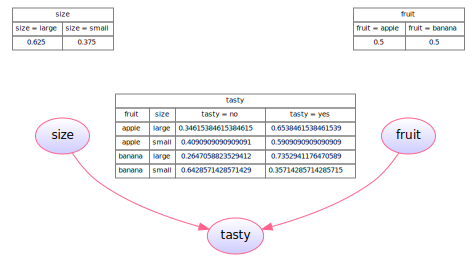

In [11]:
pgmpyToGraphCPD(fruitModel)

Another example using `fit()` with `BayesianEstimator`:

In [12]:
# Generate data:
data: DataFrame = pd.DataFrame(data = np.random.randint(low = 0, high = 2, size = (5000, 4)),
                               columns = ['A', 'B', 'C', 'D'])

model: BayesianModel = BayesianModel([('A', 'B'), ('A', 'C'), ('D', 'C'), ('B', 'D')])

model.fit(data, estimator = BayesianEstimator, prior_type = 'BDeu') #leaving equivalent_sample_size = 5 , as in default

for cpd in model.get_cpds():
    print(cpd)

+------+----------+
| A(0) | 0.497602 |
+------+----------+
| A(1) | 0.502398 |
+------+----------+
+------+--------------------+-------------------+
| A    | A(0)               | A(1)              |
+------+--------------------+-------------------+
| B(0) | 0.5277052800642441 | 0.495227679459137 |
+------+--------------------+-------------------+
| B(1) | 0.4722947199357559 | 0.504772320540863 |
+------+--------------------+-------------------+
+------+---------------------+---------------------+---------------------+---------------------+
| A    | A(0)                | A(0)                | A(1)                | A(1)                |
+------+---------------------+---------------------+---------------------+---------------------+
| D    | D(0)                | D(1)                | D(0)                | D(1)                |
+------+---------------------+---------------------+---------------------+---------------------+
| C(0) | 0.48365557105840146 | 0.516582406471183   | 0.5260745569

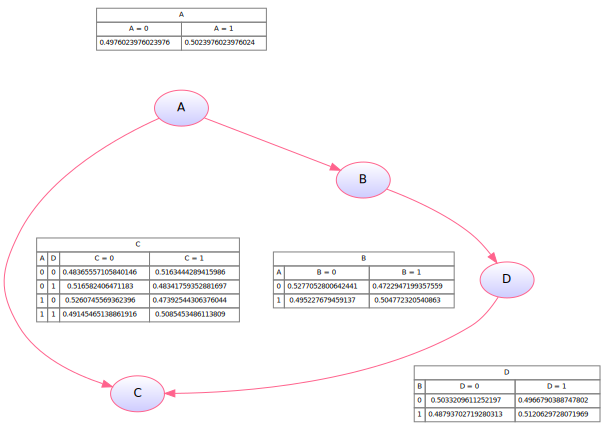

In [13]:
pgmpyToGraphCPD(model)

## Structure Learning
To learn model structure (a DAG) from a data set, there are two broad techniques:
* score-based structure learning
* constraint-based structure learning

The combination of both techniques allows further improvement:
* hybrid structure learning

### Score-Based Structure Learning
This approach construes / interprets model selection as an optimization task. It has two building blocks:
* A **scoring function**   $\;\;s_D : \; M \rightarrow \mathbb{R}\;\;$ that maps models to a numerical score, based on how well they fit to a given data set $D$.
* A **search strategy** to traverse the search space of possible models $M$ and select a model with optimal score.

### Scoring Functions
Commonly used scores to meausre the fit between model and data are: *Bayesian Dirichlet scores* like *BDeu* or *K2* and the *Bayesian Information Criterion (BIC)*. (*BDeu* is dependent on the `equivalent_sample_size` argument)

**Example 1:** $Z = X + Y$

In [14]:
from pgmpy.estimators import BDeuScore, K2Score, BicScore

# Create random data sample with 3 variables, where Z is dependent on X, Y:
data: DataFrame = DataFrame(data = np.random.randint(low=0, high = 4, size=(5000,2)),
                            columns = list('XY'))

# Making Z dependent (in some arbitrary relation like addition) on X and Y
data['Z'] = data['X'] + data['Y']

In [15]:
# Creating the scoring objects from this data:
bdeu: BDeuScore = BDeuScore(data, equivalent_sample_size = 5)
k2: K2Score = K2Score(data = data)
bic: BicScore = BicScore(data = data)

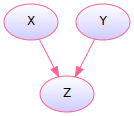

In [16]:
commonEvidenceModel: BayesianModel = BayesianModel([('X', 'Z'), ('Y', 'Z')])
pgmpyToGraph(commonEvidenceModel)

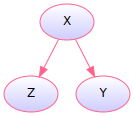

In [17]:
commonCauseModel: BayesianModel = BayesianModel([('X', 'Z'), ('X', 'Y')])
pgmpyToGraph(commonCauseModel)

In [18]:
bdeu.score(commonEvidenceModel)

-13939.583367801844

In [19]:
k2.score(commonEvidenceModel)

-14330.412434366044

In [20]:
bic.score(commonEvidenceModel)

-14295.622133947189

The `commonEvidenceModel` is the correct model for the data relationship $ Z = X + Y$ and scores higher than the `commonCauseModel`, as expected.

$\color{red}{\text{TODO: }}$ why higher BIC scores good here? Thought lower BIC is good, which would indicated `commmonCauseModel` is better...?

In [21]:
bdeu.score(commonCauseModel)

-20905.17513233854

In [22]:
k2.score(commonCauseModel)

-20932.005676111818

In [23]:
bic.score(commonCauseModel)

-20949.21721423049

* KEY NOTE: these scores *decompose* so they can be computed locally for each of the variables, **given** their **potential parents**, while **independent** of other parts of the network:

In [24]:
bdeu.local_score(variable = 'Z', parents = [])

-9240.430476374133

In [25]:
bdeu.local_score(variable = 'Z', parents = ['X'])

-6993.0180228513345

In [26]:
bdeu.local_score(variable = 'Z', parents = ['X', 'Y'])

-57.12114165948901

The local score is highest when both parents are considered, which reflects the data relation $Z = X + Y$

**Example 2:** Fruit Data

In [27]:
bdeuFruit: BDeuScore = BDeuScore(fruitData, equivalent_sample_size = 10)
k2Fruit: K2Score = K2Score(data = fruitData)
bicFruit: BicScore = BicScore(data = fruitData)

print("BDeu = ", bdeuFruit.score(fruitModel))
print("k2 = ", k2Fruit.score(fruitModel))
print("bic = ", bicFruit.score(fruitModel))

BDeu =  -29.296104564686555
k2 =  -30.377209364312794
bic =  -32.859257093436106


In [28]:
print(bdeuFruit.local_score(variable = 'fruit', parents = []))
print(k2Fruit.local_score(variable = 'fruit', parents = []))
print(bicFruit.local_score(variable = 'fruit', parents = []))

-10.15634005663103
-10.848948661710061
-11.023589192646861


In [29]:
print(bdeuFruit.local_score(variable = 'size', parents = []))
print(k2Fruit.local_score(variable = 'size', parents = []))
print(bicFruit.local_score(variable = 'size', parents = []))

-9.365131662894871
-9.616804980417431
-9.695302905001226


In [30]:
print(bdeuFruit.local_score(variable = 'tasty', parents = []))
print(k2Fruit.local_score(variable = 'tasty', parents = []))
print(bicFruit.local_score(variable = 'tasty', parents = []))

-9.365131662894871
-9.616804980417431
-9.695302905001226


In [31]:
print(bdeuFruit.local_score(variable = 'tasty', parents = ['size']))
print(k2Fruit.local_score(variable = 'tasty', parents = ['size']))
print(bicFruit.local_score(variable = 'tasty', parents = ['size']))

-9.276612974748627


-9.60575514423085
-10.415670287236923


In [32]:
print(bdeuFruit.local_score(variable = 'tasty', parents = ['fruit']))
print(k2Fruit.local_score(variable = 'tasty', parents = ['fruit']))
print(bicFruit.local_score(variable = 'tasty', parents = ['fruit']))

-9.811037897741208
-10.247927958806514
-11.01483156980886


In [33]:
print(bdeuFruit.local_score(variable = 'tasty', parents = ['size', 'fruit']))
print(k2Fruit.local_score(variable = 'tasty', parents = ['size', 'fruit']))
print(bicFruit.local_score(variable = 'tasty', parents = ['size', 'fruit']))

-9.774632845160651
-9.911455722185304


-12.140364995788019


### Search Strategies
The search space of DAGs is super-exponential in the number of variables and the above scoring functions allow for local maxima. The first property makes exhaustive search intractable for all but very small networks, the second prohibits efficient local optimization algorithms to always find the optimal structure. Thus, identifiying the ideal structure is often not tractable. Despite these bad news, heuristic search strategies often yields good results.

If only few nodes are involved (read: less than 5), ExhaustiveSearch can be used to compute the score for every DAG and returns the best-scoring one:

#### Exhaustive Search
**Example 1:** $Z + X + Y$

In [34]:
from pgmpy.estimators import ExhaustiveSearch
from pgmpy.base.DAG import DAG

es: ExhaustiveSearch = ExhaustiveSearch(data = data, scoring_method = bic)
bestModel: DAG = es.estimate()

bestModel.edges()

OutEdgeView([('X', 'Z'), ('Y', 'Z')])

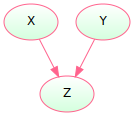

In [35]:
# The best model (structurally estimated):
pgmpyToGraph(bestModel, nodeColor = LIGHT_GREEN)

In [36]:
# Computing scores for all structurally analyzed DAGS:

print("All DAGs sorted by score:\n")

for score, dag in reversed(es.all_scores()):
    print(f"Score = {score},   Edges: {dag.edges()}")

All DAGs sorted by score:



Score = -14295.622133947189,   Edges: [('X', 'Z'), ('Y', 'Z')]
Score = -14329.415571407193,   Edges: [('Y', 'X'), ('Z', 'X'), ('Z', 'Y')]
Score = -14329.415571407195,   Edges: [('Y', 'Z'), ('Y', 'X'), ('Z', 'X')]
Score = -14329.415571407195,   Edges: [('X', 'Z'), ('Y', 'Z'), ('Y', 'X')]
Score = -14329.415571407195,   Edges: [('X', 'Y'), ('Z', 'X'), ('Z', 'Y')]
Score = -14329.415571407195,   Edges: [('X', 'Y'), ('X', 'Z'), ('Z', 'Y')]
Score = -14329.415571407195,   Edges: [('X', 'Y'), ('X', 'Z'), ('Y', 'Z')]
Score = -16545.11884196989,   Edges: [('X', 'Y'), ('Z', 'Y')]
Score = -16545.78262001622,   Edges: [('Y', 'X'), ('Z', 'X')]
Score = -18699.056728161457,   Edges: [('Z', 'X'), ('Z', 'Y')]
Score = -18699.056728161457,   Edges: [('Y', 'Z'), ('Z', 'X')]
Score = -18699.056728161457,   Edges: [('X', 'Z'), ('Z', 'Y')]
Score = -20914.75999872415,   Edges: [('Z', 'Y')]
Score = -20914.759998724152,   Edges: [('Y', 'Z')]
Score = -20915.423776770484,   Edges: [('Z', 'X')]
Score = -20915.4237767

Drawing a few of the highest-scoring ones and lowest-scoring ones

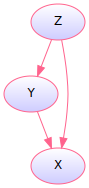

In [37]:
from networkx.classes.digraph import DiGraph


scoresAndDags: List[Tuple[float, DiGraph]] = list(reversed(es.all_scores()))
LEN = len(scoresAndDags)

# Second-highest scoring graph
pgmpyToGraph(scoresAndDags[1][1])

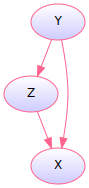

In [38]:
# Third-highest scoring graph
pgmpyToGraph(scoresAndDags[2][1])

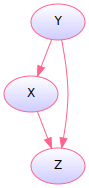

In [39]:
# Fourth-highest scoring graph
pgmpyToGraph(scoresAndDags[3][1])

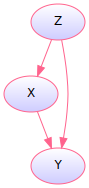

In [40]:
# Fifth-highest scoring graph
pgmpyToGraph(scoresAndDags[4][1])

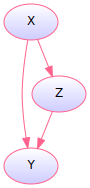

In [41]:
# Sixth-highest scoring graph
pgmpyToGraph(scoresAndDags[5][1])

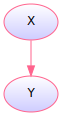

In [42]:
# Worst graph:
pgmpyToGraph(scoresAndDags[LEN-1][1])

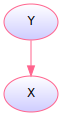

In [43]:
# Second-worst graph:
pgmpyToGraph(scoresAndDags[LEN-2][1])

**Example 2:* Fruit data

In [44]:
es: ExhaustiveSearch = ExhaustiveSearch(data = fruitData, scoring_method = bicFruit)
bestFruitModel: DAG = es.estimate()

bestFruitModel.edges()
# TODO why is this empty?

OutEdgeView([])

#### Heuristic Search
Once more ndoes are involved we need to switch to heuristic search. The `HillClimbSearch` implements a greedy local search that starts from the DAG `start` (default disconnected DAG) and proceeds by iteratively performing single-edge manipulations that maximally increase the score. The search terminates once a local maximum is found.

**Example 1:** $Z = X + Y$

In [45]:
from pgmpy.estimators import HillClimbSearch

# Create data with dependencies:
data: DataFrame = DataFrame(np.random.randint(low = 0, high = 3, size=(2500,8)),
                            columns = list('ABCDEFGH'))
data['A'] += data['B'] + data['C']
data['H'] = data['G'] - data['A']


hc = HillClimbSearch(data = data, scoring_method = BicScore(data))

bestModel = hc.estimate()

In [46]:
bestModel.edges()

OutEdgeView([('A', 'B'), ('A', 'C'), ('C', 'B'), ('G', 'A'), ('G', 'H'), ('H', 'A')])

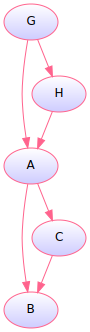

In [47]:
pgmpyToGraph(bestModel)

The search correctly identifies that $B$ and $C$ do not influence $H$ directly, only through $A$ and of course that $D$, $E$, $F$ are independent.

To enforce a wider exploration of the search space, the search can be enhanced with a tabu list. The list keeps track of the last n modfications; those are then not allowed to be reversed, regardless of the score. Additionally a `white_list` or `black_list` can be supplied to restrict the search to a particular subset or to exclude certain edges. The parameter `max_indegree` allows to restrict the maximum number of parents for each node.

**Example 2:** Fruit data

In [48]:
hc = HillClimbSearch(fruitData, scoring_method = BicScore(fruitData))
bestFruitModel: DAG = hc.estimate()

bestFruitModel.edges()
#pgmpyToGraph(bestFruitModel)

# TODO why is this empty??



OutEdgeView([])

### Constraint-Based Structure Learning
A different but straightforward approach to build a DAG from data is:
1. Identify independencies in the data set using hypothesis tests
2. Construct DAG (pattern) according to these independencies.

#### Conditional Independence Tests
Independencies in the data can be identified using $\chi$-squared conditional independence hypothesis tests. Constraint-based estimators in pgmpy have a `test_conditional_independence(X, Y, Z)` method that performs a hypothesis test on the data sample to check if $X$ is independent from $Y$ given a set of variables $Z$s.

**Example 1:** Linear Relationships Data

In [49]:
from pgmpy.estimators import ConstraintBasedEstimator

data: DataFrame = DataFrame(data = np.random.randint(low=0, high=3, size=(2500,8)),
                            columns=list('ABCDEFGH'))
data['A'] += data['B'] + data['C']
data['H'] = data['G'] - data['A']
data['E'] *= data['F']

est: ConstraintBasedEstimator = ConstraintBasedEstimator(data = data)


assert not est.test_conditional_independence('B', 'H')
assert est.test_conditional_independence('B', 'E')
assert not est.test_conditional_independence('A', 'B')

assert est.test_conditional_independence(X = 'B', Y = 'H', Zs = ['A'])

assert est.test_conditional_independence('A', 'G')

assert not est.test_conditional_independence('A', 'G', Zs = ['H'])
assert not est.test_conditional_independence('A', 'H', Zs = ['G'])

`test_conditional_independence()` returns a triple `(chi2, pValue, sufficientData)` consisting of the computed $\chi$-squared test statistic, the `pValue` of the test, and a heuristic flag that indicates if the sample size was sufficient. The `pValue` is the probability of observing the computed $\chi$-squared statistic (or an even higher $\chi$-squared value) given the null hypothesis that $X$ and $Y$ are independent given $Z$s.

$\color{red}{\text{TODO: this is not true!}}$

#### DAG (pattern) Construction
Can now construct a DAG from the data set in three steps:

1. `estimate_skeleton()`: Construct an undirected skeleton using `estimate_skeleton()`. The job of `estimate_skeleton()` is: to estimate a graph skeleton (UndirectedGraph) for the data set. Uses the `build_skeleton` method (PC algorithm); independencies are determined using a chisquare statistic with the acceptance threshold of `significance_level`. Returns
   * `skeleton`: `UndirectedGraph` = An estimate for the undirected graph skeleton of the BN underlying the data.
   * `separating_sets`: dict = A dict containing for each pair of not directly connected nodes a separating set of variables that makes them conditionally independent. (needed for edge orientation procedures)
2. `skeleton_to_pdag()`: Orient compelled edges to obtain partially directed acyclic graph (PDAG, I-equivalence class of DAGs) using `skeleton_to_pdag()`, which takes the outputted `skeleton` and `separating_sets` to create a DAG pattern. Returns:
      * pdag: `DAG` = An estimate for the DAG pattern of the BN underlying the data. The graph might contain some nodes with both-way edges (X->Y and Y->X). Any completion by (removing one of the both-way edges for each such pair) results in a I-equivalent Bayesian network DAG.
3. `pdag_to_dag()`: Extend DAG pattern to a DAG by conservatively orienting the remaining edges in some way, using `pdag_to_dag()`.Completes a PDAG to a DAG, without adding v-structures, if such a completion exists. If no faithful extension is possible, some fully oriented DAG that corresponds to the PDAG is returned and a warning is generated. This is a static method. Returns:
      * dag: `DAG` = A faithful orientation of pdag, if one exists. Otherwise any fully orientated DAG/BayesianModel with the structure of pdag.

PDAGs are `DirectedGraph`s that may contain both-way edges, to indicate that the orientation for the edge is not determined.

In [50]:
from pgmpy.base.UndirectedGraph import UndirectedGraph

skel, separatingSets = est.estimate_skeleton(significance_level = 0.01)
skel: UndirectedGraph = skel

print("Undirected edges: ", skel.edges())

Undirected edges:  [('A', 'B'), ('A', 'C'), ('A', 'H'), ('E', 'F'), ('G', 'H')]


In [51]:
separatingSets

{frozenset({'A', 'D'}): (),
 frozenset({'A', 'E'}): (),
 frozenset({'A', 'F'}): (),
 frozenset({'A', 'G'}): (),
 frozenset({'B', 'C'}): (),
 frozenset({'B', 'D'}): (),
 frozenset({'B', 'E'}): (),
 frozenset({'B', 'F'}): (),
 frozenset({'B', 'G'}): (),
 frozenset({'C', 'D'}): (),
 frozenset({'C', 'E'}): (),
 frozenset({'C', 'F'}): (),
 frozenset({'C', 'G'}): (),
 frozenset({'D', 'E'}): (),
 frozenset({'D', 'F'}): (),
 frozenset({'D', 'G'}): (),
 frozenset({'D', 'H'}): (),
 frozenset({'E', 'G'}): (),
 frozenset({'E', 'H'}): (),
 frozenset({'F', 'G'}): (),
 frozenset({'F', 'H'}): (),
 frozenset({'B', 'H'}): ('A',),
 frozenset({'C', 'H'}): ('A',)}

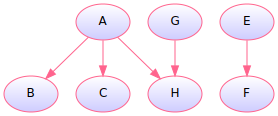

In [52]:
# Remember this draws the graph as directed, but in fact the edges are undirected.
pgmpyToGraph(skel)

In [53]:
from networkx.classes.digraph import DiGraph

pdag: DiGraph = est.skeleton_to_pdag(skel = skel, separating_sets = separatingSets)

print("PDAG edges: ", pdag.edges())

PDAG edges:  [('A', 'H'), ('B', 'A'), ('C', 'A'), ('E', 'F'), ('F', 'E'), ('G', 'H')]


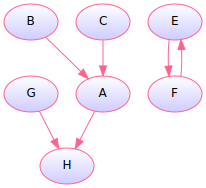

In [54]:
pgmpyToGraph(pdag) # This is a directed graph (but how to show only partially?)

DAG edges:  [('A', 'H'), ('B', 'A'), ('C', 'A'), ('F', 'E'), ('G', 'H')]


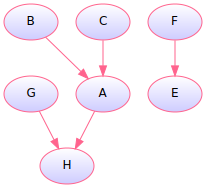

In [55]:
model: DAG = est.pdag_to_dag(pdag = pdag)
print("DAG edges: ", model.edges())


pgmpyToGraph(model)

The `estimate()` method gives a shorthand for the three steps and directly reutrns a `BayesianModel`:

$\color{red}{\text{TODO}}$ it is not actually a `BayesianModel` it is still a `DAG`

In [56]:
estModel: DAG = est.estimate(significance_level = 0.01)

assert estModel.edges() == model.edges(), "Check: both methods of getting the estimated DAG are equivalent"

estModel.edges()

OutEdgeView([('A', 'H'), ('B', 'A'), ('C', 'A'), ('F', 'E'), ('G', 'H')])

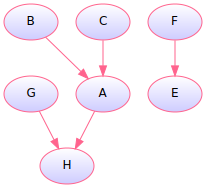

In [57]:
pgmpyToGraph(estModel)

The `estimate_from_independencies()` method can be used to create a `BayesianModel` from a provided *set of independencies*.

Estimates a DAG from an `Independencies()`-object or a decision function for conditional independencies. This requires that the set of independencies admits a faithful representation (e.g. is a set of d-separation for some BN or is closed under the semi-graphoid axioms).

* NOTE: **Meaning of Faithful**: PC PDAG construction is only guaranteed to work under the assumption that the identified set of independencies is **faithful**, i.e. there exists a DAG that exactly corresponds to it. Spurious dependencies in the data set can cause the reported independencies to violate faithfulness. It can happen that the estimated PDAG does not have any faithful completions (i.e. edge orientations that do not introduce new v-structures). In that case a warning is issued.

In [58]:
ind: Independencies = Independencies(['B', 'C'], ['A', ['B', 'C'], 'D'])

indClosure: Independencies = ind.closure()  #required for faithfulness

indModel = ConstraintBasedEstimator.estimate_from_independencies(nodes = "ABCD", independencies = indClosure)

indModel.edges()

OutEdgeView([('A', 'D'), ('B', 'D'), ('C', 'D')])

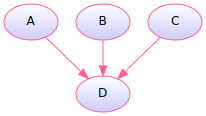

In [59]:
pgmpyToGraph(indModel)




### Hybrid Structure Learning
The MMHC algorithm combines constraint-based and score-based structure learning methods. It has two parts:

1. Learn an undirected graph skeleton using the constraint-based construction procedure MMPC
2. Orient edges using score-based optimization (BDeu score + modified hill-climbing)

Can perform these two steps somewhat separately:

In [60]:
from pgmpy.estimators import MmhcEstimator
from pgmpy.estimators import BDeuScore

data: DataFrame = DataFrame(data = np.random.randint(low = 0, high = 3, size=(2500, 8)),
                            columns = list("ABCDEFGH"))

data['A'] += data['B'] + data['C']
data['H'] = data['G'] - data['A']
data['E'] *= data['F']

**Part 1:** Learning the Unidirected graph skeleton using `MMPC` algorithm (constraint-based method)

/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing A _|_ E | ['C', 'B', 'H']. At least 7290 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing A _|_ G | ['C', 'B', 'H']. At least 4860 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing A _|_ D | ['C', 'B', 'H']. At least 4860 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing A _|_ F | ['C', 'B', 'H']. At least 4860 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing A _|_ E | ['C', 'H', 'G']. At least 7290 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing A _|_ E | ['B', 'H', 'G']. At least 7290 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing A _|_ E | ['C', 'B', 'H', 'G']. At least 21870 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing A _|_ D | ['C', 'H', 'G']. At least 4860 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing A _|_ D | ['B', 'H', 'G']. At least 4860 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing A _|_ D | ['C', 'B', 'H', 'G']. At least 14580 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing A _|_ F | ['C', 'H', 'G']. At least 4860 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing A _|_ F | ['B', 'H', 'G']. At least 4860 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing A _|_ F | ['C', 'B', 'H', 'G']. At least 14580 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing B _|_ E | ['A', 'H', 'C']. At least 5670 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing B _|_ G | ['A', 'H', 'C']. At least 3780 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing B _|_ D | ['A', 'H', 'C']. At least 3780 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing B _|_ F | ['A', 'H', 'C']. At least 3780 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing C _|_ E | ['A', 'H', 'B']. At least 5670 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing C _|_ G | ['A', 'H', 'B']. At least 3780 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing C _|_ D | ['A', 'H', 'B']. At least 3780 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing C _|_ F | ['A', 'H', 'B']. At least 3780 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing D _|_ H | ['B', 'F', 'A']. At least 5040 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing E _|_ H | ['F', 'B', 'C']. At least 3240 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing E _|_ H | ['F', 'A']. At least 2520 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing E _|_ H | ['B', 'A']. At least 2520 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing E _|_ H | ['C', 'A']. At least 2520 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing E _|_ H | ['F', 'B', 'A']. At least 7560 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing E _|_ H | ['F', 'C', 'A']. At least 7560 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing E _|_ H | ['B', 'C', 'A']. At least 7560 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing E _|_ H | ['F', 'B', 'C', 'A']. At least 22680 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing E _|_ G | ['F', 'B', 'C', 'A']. At least 5670 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing E _|_ D | ['F', 'B', 'C', 'A']. At least 5670 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing F _|_ H | ['E', 'B', 'A']. At least 6720 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing G _|_ E | ['H', 'B', 'A']. At least 5670 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing G _|_ C | ['H', 'B', 'A']. At least 3780 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing G _|_ D | ['H', 'B', 'A']. At least 3780 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing G _|_ F | ['H', 'B', 'A']. At least 3780 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing H _|_ E | ['C', 'A']. At least 2520 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing H _|_ E | ['A', 'G']. At least 2520 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing H _|_ E | ['C', 'A', 'G']. At least 7560 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing H _|_ B | ['C', 'A', 'G']. At least 5040 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing H _|_ D | ['C', 'A', 'G']. At least 5040 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing H _|_ F | ['C', 'A', 'G']. At least 5040 samples recommended, 2500 present.
  5 * num_params, len(data)


part 1) skeleton:  [('A', 'B'), ('A', 'H'), ('B', 'C'), ('E', 'F'), ('G', 'H')]


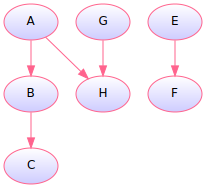

In [61]:
mmhc: MmhcEstimator = MmhcEstimator(data = data)


### Part 1) Skeleton structure estimation
# Estimates a graph skeleton (UndirectedGraph) for the data set, using then MMPC (max-min parents-and-children) algorithm.
skeleton: UndirectedGraph = mmhc.mmpc()


print("part 1) skeleton: ", skeleton.edges())
# Remember this is supposed to be UNIDRECTED graph so ignore the directions
pgmpyToGraph(skeleton)

* **NOTE:** Showing the meaning of `to_directed()` method in the next code (used to create the hybrid model)

In [62]:
# NOTE: the to_directed() method makes a mirror image of the existing edge. So if there is E --> D then the method also adds D --> E.
print("Skeleton (undirected) edges: ", list(iter(skeleton.edges())) ) #== [('A', 'H'), ('D', 'E'), ('E', 'F'), ('G', 'H')]

print("Skeleton (directed) edges: ", list(iter(skeleton.to_directed().edges())) ) #== [('A', 'H'), ('D', 'E'), ('E', 'D'), ('E', 'F'), ('F', 'E'), ('G', 'H'), ('H', 'A'), ('H', 'G')]

Skeleton (undirected) edges:  [('A', 'B'), ('A', 'H'), ('B', 'C'), ('E', 'F'), ('G', 'H')]
Skeleton (directed) edges:  [('A', 'B'), ('A', 'H'), ('B', 'A'), ('B', 'C'), ('C', 'B'), ('E', 'F'), ('F', 'E'), ('G', 'H'), ('H', 'A'), ('H', 'G')]


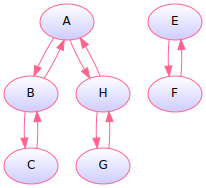

In [63]:
pgmpyToGraph(skeleton.to_directed())

**Part 2:** Orienting Edges using Score-Based Optimization

Part 2) Model:  [('A', 'H'), ('A', 'B'), ('C', 'B'), ('F', 'E'), ('G', 'H')]


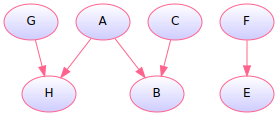

In [64]:
# Use hill climb search to orient the edges
hc: HillClimbSearch = HillClimbSearch(data = data, scoring_method = BDeuScore(data))

### Part 2) Model estimation
# NOTE: providing the white list argument limits the search to edges only in white list
modelHybrid: DAG = hc.estimate(tabu_length = 10,
                               white_list = skeleton.to_directed().edges())



print("Part 2) Model: ", modelHybrid.edges())

pgmpyToGraph(modelHybrid)

`MmhcEstimator.estimate()` combines both these steps and directly estimates a `BayesianModel`.

Creating the model the short way:

/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing A _|_ E | ['C', 'B', 'H']. At least 7290 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing A _|_ G | ['C', 'B', 'H']. At least 4860 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing A _|_ D | ['C', 'B', 'H']. At least 4860 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing A _|_ F | ['C', 'B', 'H']. At least 4860 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing A _|_ E | ['C', 'H', 'G']. At least 7290 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing A _|_ E | ['B', 'H', 'G']. At least 7290 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing A _|_ E | ['C', 'B', 'H', 'G']. At least 21870 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing A _|_ D | ['C', 'H', 'G']. At least 4860 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing A _|_ D | ['B', 'H', 'G']. At least 4860 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing A _|_ D | ['C', 'B', 'H', 'G']. At least 14580 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing A _|_ F | ['C', 'H', 'G']. At least 4860 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing A _|_ F | ['B', 'H', 'G']. At least 4860 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing A _|_ F | ['C', 'B', 'H', 'G']. At least 14580 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing B _|_ E | ['A', 'H', 'C']. At least 5670 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing B _|_ G | ['A', 'H', 'C']. At least 3780 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing B _|_ D | ['A', 'H', 'C']. At least 3780 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing B _|_ F | ['A', 'H', 'C']. At least 3780 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing C _|_ E | ['A', 'H', 'B']. At least 5670 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing C _|_ G | ['A', 'H', 'B']. At least 3780 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing C _|_ D | ['A', 'H', 'B']. At least 3780 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing C _|_ F | ['A', 'H', 'B']. At least 3780 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing D _|_ H | ['B', 'F', 'A']. At least 5040 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing E _|_ H | ['F', 'B', 'C']. At least 3240 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing E _|_ H | ['F', 'A']. At least 2520 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing E _|_ H | ['B', 'A']. At least 2520 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing E _|_ H | ['C', 'A']. At least 2520 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing E _|_ H | ['F', 'B', 'A']. At least 7560 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing E _|_ H | ['F', 'C', 'A']. At least 7560 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing E _|_ H | ['B', 'C', 'A']. At least 7560 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing E _|_ H | ['F', 'B', 'C', 'A']. At least 22680 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing E _|_ G | ['F', 'B', 'C', 'A']. At least 5670 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing E _|_ D | ['F', 'B', 'C', 'A']. At least 5670 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing F _|_ H | ['E', 'B', 'A']. At least 6720 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing G _|_ E | ['H', 'B', 'A']. At least 5670 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing G _|_ C | ['H', 'B', 'A']. At least 3780 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing G _|_ D | ['H', 'B', 'A']. At least 3780 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing G _|_ F | ['H', 'B', 'A']. At least 3780 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing H _|_ E | ['C', 'A']. At least 2520 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing H _|_ E | ['A', 'G']. At least 2520 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing H _|_ E | ['C', 'A', 'G']. At least 7560 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing H _|_ B | ['C', 'A', 'G']. At least 5040 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing H _|_ D | ['C', 'A', 'G']. At least 5040 samples recommended, 2500 present.
  5 * num_params, len(data)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/CITests.py:95: UserWarning: Insufficient data for testing H _|_ F | ['C', 'A', 'G']. At least 5040 samples recommended, 2500 present.
  5 * num_params, len(data)


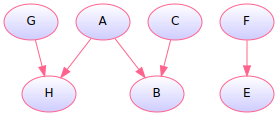

In [65]:
modelMMHC: DAG = mmhc.estimate(scoring_method = BDeuScore(data), tabu_length = 10)

assert modelMMHC.edges() == modelHybrid.edges()

pgmpyToGraph(modelMMHC)